In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os

# US Senate

In [2]:
pwd

'/Users/peterhorton/Documents/RDH/pdv/pdv-va/vest-va-2018'

### VEST File - Load

In [3]:
#Check out final file: https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/UBKYRU/FQDLOO&version=33.0 
final = gpd.read_file('./vest_va/va_2018_senate/va_2018_senate.shp')
print(final.shape)
final.head()

(2463, 9)


,COUNTYFP,LOCALITY,VTDST,PRECINCT,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,geometry
0,001,Accomack County,000101,Chincoteague,556,994,17,0,"POLYGON Z ((-75.42507 37.89957 0.00000, -75.42..."
1,001,Accomack County,000201,Atlantic,182,459,11,0,"POLYGON Z ((-75.59978 37.87664 0.00000, -75.59..."
2,001,Accomack County,000202,Greenbackville,316,577,8,1,"POLYGON Z ((-75.49919 37.93416 0.00000, -75.49..."
3,001,Accomack County,000301,New Church,588,477,11,0,"POLYGON Z ((-75.64987 37.92702 0.00000, -75.64..."
4,001,Accomack County,000401,Bloxom,121,277,4,0,"POLYGON Z ((-75.71556 37.87513 0.00000, -75.71..."


# Election Results: US Senate 

In [4]:
#US senate results from the state: https://historical.elections.virginia.gov/elections/view/134055/ 
df = pd.read_csv('./vest_va/Virginia_Elections_Database__2018_U_S_Senate_General_Election_including_precincts.csv')
df.head()

,County/City,Ward,Pct,Timothy Michael Kaine,Corey Alan Stewart,Matthew Joseph Waters,All Others,Total Votes Cast
0,NaN,NaN,NaN,Democratic,Republican,Libertarian,NaN,NaN
1,Accomack County,-,101 - Chincoteague,487,932,16,0,"1,435"
2,Accomack County,-,201 - Atlantic,159,430,10,0,599
3,Accomack County,-,202 - Greenbackville,277,541,7,1,826
4,Accomack County,-,301 - New Church,515,447,10,0,972


## Format election results to match VEST

In [5]:
set(df['County/City']) - set(final['LOCALITY'])

{'TOTALS', nan}

In [6]:
df['LOCALITY'] = df['County/City']
df['G18USSDKAI'] = df['Timothy Michael Kaine']
df['G18USSRSTE'] = df['Corey Alan Stewart']
df['G18USSLWAT'] = df['Matthew Joseph Waters']
df['G18USSOWRI'] = df['All Others']
df = df.iloc[1:]
df = df.drop(['County/City', 'Ward', 'Timothy Michael Kaine', 'Corey Alan Stewart', 'Matthew Joseph Waters', 'All Others', 'Total Votes Cast'], axis = 1)

#Add in county fips column to raw election results (df)
county_dict = pd.Series(final['COUNTYFP'].values, index = final['LOCALITY']).to_dict()
df['COUNTYFP'] = df['LOCALITY'].map(county_dict)

#Change type of election results so they can be summed, compared etc.
df.loc[:,'G18USSDKAI'] = df['G18USSDKAI'].map(lambda x: x.replace(',', ''))
df.loc[:,'G18USSRSTE'] = df['G18USSRSTE'].map(lambda x: x.replace(',', ''))
df.loc[:,'G18USSLWAT'] = df['G18USSLWAT'].map(lambda x: x.replace(',', ''))
df.loc[:,'G18USSOWRI'] = df['G18USSOWRI'].map(lambda x: x.replace(',', ''))

df['G18USSDKAI'] = df['G18USSDKAI'].astype(str).astype(int)
df['G18USSRSTE'] = df['G18USSRSTE'].astype(str).astype(int)
df['G18USSLWAT'] = df['G18USSLWAT'].astype(str).astype(int)
df['G18USSOWRI'] = df['G18USSOWRI'].astype(str).astype(int)

df = df[df["LOCALITY"]!="TOTALS"]

df.head()

,Pct,LOCALITY,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,COUNTYFP
1,101 - Chincoteague,Accomack County,487,932,16,0,001
2,201 - Atlantic,Accomack County,159,430,10,0,001
3,202 - Greenbackville,Accomack County,277,541,7,1,001
4,301 - New Church,Accomack County,515,447,10,0,001
5,401 - Bloxom,Accomack County,106,260,4,0,001


## Check column totals

In [7]:
column_list = ['G18USSDKAI', 'G18USSRSTE', 'G18USSLWAT', 'G18USSOWRI']

In [8]:
for val in column_list:
    vote_dif = df[val].sum()-final[val].sum()
    if (vote_dif == 0):
        print(val+": EQUAL")
    else:
        print(val+": DIFFERENCE OF " + str(vote_dif)+ " VOTES")

G18USSDKAI: EQUAL
G18USSRSTE: EQUAL
G18USSLWAT: EQUAL
G18USSOWRI: EQUAL


In [9]:
print("Columns with differences printed below:")
diff_columns=[]
for i in column_list:
    diff = df.groupby(["COUNTYFP"]).sum()[i]-final.groupby(["COUNTYFP"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_columns:
            diff_columns.append(val)
    if len(diff[diff != 0]!=0):
        print(diff[diff != 0].to_string(header=False))
print("")
print("All other races in all columns are equal")

Columns with differences printed below:

All other races in all columns are equal


## Reallocate Absentee Votes

### Add cd to county name to account for counties split by congressional districts where relevant

In [10]:
cd_abs_prov_prec = df[((df['Pct'].map(lambda x: 'Absentee' in str(x))) &(df['Pct'].map(lambda x: 'CD' in str(x)))) | ((df['Pct'].map(lambda x: 'Provisional' in str(x))) & (df['Pct'].map(lambda x: 'CD' in str(x))))]
county_with_cd_nec_list = list(cd_abs_prov_prec['COUNTYFP'])

def add_cd_to_county(county_list, precinct, countyfp):
    if (countyfp in county_list):
        countyfp_cd = countyfp + '-' + precinct[-5:-1]
        return countyfp_cd
    else:
        countyfp_cd = countyfp
        return countyfp_cd
    
df['countyfp_cd'] = df.apply(lambda row: add_cd_to_county(county_with_cd_nec_list, row['Pct'], row['COUNTYFP']), axis = 1)

### Reallocation based on county with CD

In [11]:
#Function to get fraction of county vote precinct holds
def get_absentee_frac(prec_tot, county_tot, absentee_tot):
    '''A spec specifies in first line what function will do
    Returns fraction of county absentee votes for a precinct for a candidate
    
    Keyword arguments: (put inputs to funtions and say what they should be)
    precinct vote total for given candidate (int)
    county vote total for given candidate, absentee and provisional votes not included (int)
    absentee vote total for county for given candidate (int)
    
    "Pure function" bc only relies on inputs and outputs - only variables are ones that were passed as arguments
    '''
    if county_tot != 0:
        prec_frac = prec_tot/county_tot
        absentee_frac = prec_frac*absentee_tot
    else:
        absentee_frac = 0
    return absentee_frac

#Set up dfs that are subsets of df to groupby with or without absentee and provisional
absentee_and_prov = df[(df['Pct'].map(lambda x: 'Absentee' in str(x))) | (df['Pct'].map(lambda x: 'Provisional' in str(x)))]
groupby_absentee_and_prov_tot = absentee_and_prov.groupby(['countyfp_cd']).sum()
groupby_county_df_tot = df.groupby(['countyfp_cd']).sum()
df_no_absent_or_provisional = df[(df['Pct'].map(lambda x: 'Absentee' not in str(x))) & (df['Pct'].map(lambda x: 'Provisional' not in str(x)))
                                & (df['LOCALITY'] != 'TOTALS')]
groupby_county_tot_no_absentee = df_no_absent_or_provisional.groupby('countyfp_cd').sum()

df_with_absentee_reallocated = df_no_absent_or_provisional.copy()
groupby_absentee_and_prov_tot.reset_index(inplace=True,drop=False)
groupby_county_tot_no_absentee.reset_index(inplace=True,drop=False)

to_dole_out_totals = groupby_absentee_and_prov_tot.copy()
precinct_specific_totals = groupby_county_tot_no_absentee.copy()

In [12]:
## PH CODE for vote allocation


#countyfp_cd
#df_no_absent_or_provisional

column_list = ['G18USSDKAI', 'G18USSRSTE', 'G18USSLWAT', 'G18USSOWRI']

#Create some new columns for each of these races to deal with the allocation
for race in column_list:
    add_var = race+"_add"
    rem_var = race+"_rem"
    floor_var = race+"_floor"
    df_with_absentee_reallocated.loc[:,add_var]=0.0
    df_with_absentee_reallocated.loc[:,rem_var]=0.0
    df_with_absentee_reallocated.loc[:,floor_var]=0.0

#Iterate over the rows
#Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
for index, row in df_no_absent_or_provisional.iterrows():
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        #Grab the district
        county_id = row["countyfp_cd"]
        #Get the denominator for the allocation (the precinct vote totals)
        denom = precinct_specific_totals.loc[precinct_specific_totals["countyfp_cd"]==county_id][race]
        #Get one of the numerators, how many districtwide votes to allocate
        numer = to_dole_out_totals.loc[to_dole_out_totals["countyfp_cd"]==county_id][race]
        #Get the vote totals for this race in this precinct
        val = df_with_absentee_reallocated.at[index,race]
        #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
        if ((float(denom)==0)):
            vote_share = 0
        else:
            vote_share = (float(val)/float(denom))*float(numer)
        df_with_absentee_reallocated.at[index,add_var] = vote_share
        #Take the decimal remainder of the allocation
        df_with_absentee_reallocated.at[index,rem_var] = vote_share%1
        #Take the floor of the allocation
        df_with_absentee_reallocated.at[index,floor_var] = np.floor(vote_share)

#After the first pass through, get the sums of the races by district to assist in the rounding            
first_allocation = pd.DataFrame(df_with_absentee_reallocated.groupby(["countyfp_cd"]).sum())

#Now we want to iterate district by district to work on rounding
county_list = list(to_dole_out_totals["countyfp_cd"].unique()) 

#Iterate over the district
for county in county_list:
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
        to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals["countyfp_cd"]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
        #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
        for index in df_with_absentee_reallocated.loc[df_with_absentee_reallocated["countyfp_cd"]==county][rem_var].nlargest(to_go).index:
            df_with_absentee_reallocated.at[index,add_var] = np.ceil(df_with_absentee_reallocated.at[index,add_var])

#Iterate over every race again
for race in column_list:
    add_var = race+"_add"
    #Round every allocation down to not add fractional votes
    df_with_absentee_reallocated.loc[:,add_var]=np.floor(df_with_absentee_reallocated.loc[:,add_var])
    df_with_absentee_reallocated.loc[:,race]+=df_with_absentee_reallocated.loc[:,add_var]
    
    #Print out any instances where the allocation, as written, won't work
for index, row in precinct_specific_totals.iterrows():
    for race in column_list:
        if (row[race]==0):
            race_district = row["countyfp_cd"]
            to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals["countyfp_cd"]==race_district,race])
            if (to_allocate != 0):
                print("Weren't able to allocate "+str(to_allocate)+" votes in " +str(race)+" county fip / cd "+str(race_district))

Weren't able to allocate 1 votes in G18USSOWRI county fip / cd 057
Weren't able to allocate 1 votes in G18USSOWRI county fip / cd 111


#### Check Totals Again

In [13]:
print(to_dole_out_totals.loc[to_dole_out_totals["countyfp_cd"].isin(["057","111"]),"G18USSOWRI"])

29    1
62    1
Name: G18USSOWRI, dtype: int64


In [14]:
print(precinct_specific_totals.loc[precinct_specific_totals["countyfp_cd"].isin(["057","111"]),"G18USSOWRI"])

29    0
62    0
Name: G18USSOWRI, dtype: int64


In [15]:
for val in column_list:
    vote_dif = df_with_absentee_reallocated[val].sum()-final[val].sum()
    if (vote_dif == 0):
        print(val+": EQUAL")
    else:
        print(val+": DIFFERENCE OF " + str(vote_dif)+ " VOTES")

G18USSDKAI: EQUAL
G18USSRSTE: EQUAL
G18USSLWAT: EQUAL
G18USSOWRI: DIFFERENCE OF -2.0 VOTES


In [16]:
print("Counties with differences printed below:")
diff_counties=[]
for i in column_list:
    diff = df_with_absentee_reallocated.groupby(["COUNTYFP"]).sum()[i]-final.groupby(["COUNTYFP"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(i)
        print(diff[diff != 0].to_string(header=False))
print("")
print("All other races in all counties are equal")

Counties with differences printed below:
G18USSOWRI
057   -1.0
111   -1.0

All other races in all counties are equal


The difference in two votes is due to two county / cd pairs where there are votes to be allocated, but no reported votes at the precinct level to inform the allocation, which as you can see below are 057 and 111.

In [17]:
empty_wi_cd = precinct_specific_totals[precinct_specific_totals["G18USSOWRI"]==0]["countyfp_cd"]
to_dole_out_totals[to_dole_out_totals["countyfp_cd"].isin(empty_wi_cd)][["countyfp_cd","G18USSOWRI"]]

,countyfp_cd,G18USSOWRI
29,057,1
44,081,0
51,091,0
62,111,1
72,135,0
88,163,0
99,183,0
121,640,0


# Shapefiles: County to Pct

## Load, Project

shapefile from census plotted above, VEST precinct shapefile below


(2462, 16)

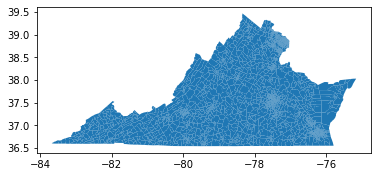

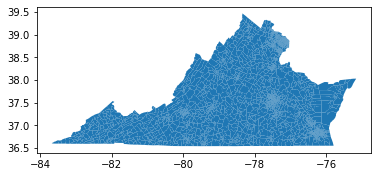

In [18]:
#create list of counties to enable next loop to load in all county shapefiles with precincts
proj = final.crs

county_fips = []
for directory in os.listdir('./vest_va/census_shps_by_county_all_unzip/'):
    if not directory[0] == '.':
        county_fips.append(directory[-5:])
        
county_vtds = []

for i in county_fips:
    ref = './vest_va/census_shps_by_county_all_unzip/partnership_shapefiles_19v2_'
    vtd_ref = ref + i + '/PVS_19_v2_vtd_' + i + '.shp' 
    vtd_shp = gpd.read_file(vtd_ref)
   # print(i, ' added to list')
    county_vtds.append(vtd_shp)
    
global shapefiles_census
shapefiles_census = gpd.GeoDataFrame(pd.concat(county_vtds, axis = 0) , crs = proj) 
print('shapefile from census plotted above, VEST precinct shapefile below')
shapefiles_census.plot()
final.plot()
shp = shapefiles_census
shp.shape

## Assigning Unique Identifier

In [19]:
#isolate 3 digit VTDST code from df that is in VEST file and shp
df_with_absentee_reallocated['vtdst'] = df_with_absentee_reallocated.Pct.str.slice(stop = 3)

def vtdst_changer(vtdst):
    if (vtdst[1:3] == ' -'):
        two_lead_zero = '00' + vtdst[:1]
        return two_lead_zero
    elif (vtdst[1:3] == '- '):
        two_lead_zero = '00' + vtdst[:1]
        return two_lead_zero
    elif (vtdst[-1:] == ' '):
        one_lead_zero = '0' + vtdst[:2]
        return one_lead_zero
    elif (vtdst[-1:] == '-'):
        one_lead_zero = '0' + vtdst[:2]
        return one_lead_zero
    else:
        return vtdst

#apply changes
df_with_absentee_reallocated['vtdst'] = df_with_absentee_reallocated['vtdst'].apply(vtdst_changer)
#Show case that it worked
df_with_absentee_reallocated[df_with_absentee_reallocated['vtdst'].str.slice(start = -1) == '-']

,Pct,LOCALITY,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,COUNTYFP,countyfp_cd,G18USSDKAI_add,G18USSDKAI_rem,...,G18USSRSTE_add,G18USSRSTE_rem,G18USSRSTE_floor,G18USSLWAT_add,G18USSLWAT_rem,G18USSLWAT_floor,G18USSOWRI_add,G18USSOWRI_rem,G18USSOWRI_floor,vtdst


Now, with vtdst in each set, make unique ID from the 2440 that do match, then account for the 10/20 that dont afterward.

In [20]:
#Assign unique id to df and vest file
df_with_absentee_reallocated['unique_id'] = df_with_absentee_reallocated['COUNTYFP'] + df_with_absentee_reallocated['vtdst']
final['unique_id'] = final.COUNTYFP + final.VTDST.str.slice(start = 3)

#identify double values and check that they are the same between df and vest file
double_in_df = df_with_absentee_reallocated['unique_id'].value_counts()
df_double_list = double_in_df[double_in_df > 1].index
double_in_final = final['unique_id'].value_counts()
final_double_list = double_in_final[double_in_final > 1].index
print(set(final_double_list) - set(df_double_list))
print(set(df_double_list) - set(final_double_list))

set()
set()


In [21]:
def vtdst_add_cd(unique_id, precinct):
    double_list = ['177702', '153112', '710104', '800602', '095504', '177103', '089505',
       '800404', '800504', '153210', '095202', '089304', '800302', '153609',
       '177703', '650215', '177402', '153312', '059513', '550020', '177704',
       '153110']
    if (unique_id in double_list):
        unique_id = unique_id + precinct[-6:]
        return unique_id
    else:
        return unique_id
    
df_with_absentee_reallocated['unique_id_1'] = df_with_absentee_reallocated.apply(lambda row: vtdst_add_cd(row['unique_id'], row['Pct']), axis = 1)
final['unique_id_1'] = final.apply(lambda row: vtdst_add_cd(row['unique_id'], row['PRECINCT']), axis = 1)

### Fixing 07 vs 99 mismatch between df and vest file

In [22]:
d = {'003407':'003499', '003507': '003599'}
df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id'].isin(d.keys()), 'unique_id_1']=df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id'].isin(d.keys()), 'unique_id_1'].map(d)

### Apply unique id to shp

In [23]:
shp['unique_id'] = shp['COUNTYFP'] + shp['VTDST'].str.slice(start = 3)

In [24]:
#Printed mismatch in sets, then compared in Excel spreadsheet, tested out plotting precincts in notebook, and hand made this dictionary
#comments next to key:value pairs indicate needed changes
merge_dict = {'153114': '153109', #? do not look like they matchPiney Branch
 '153061': '153106', #Westgate part 1 -- on map looks like it this is the only match ?merge
 '153062': '153106', #?merge Westgate part 2 -- westgate is normal Polygon z in final file
 #: 153315 - Williams voting District from shp does not seem to have a match in df
 '191021': '191702', #merge Wallace part 1
 '191022': '191702', #merge Wallace part 2 -- multipolygon in final file - merge shp
 '760415': '760114', #? does not look like it matches based on polygons only one that contains 4 that is not in shp file also??
 #no match in 760 county for : 760215 from shp dataset
 #no match in 750 county for : '750004'
 '685031': '685003', #merge Precint three part 1
 '685032': '685003', #merge Precinct three part 2
 #: 059700 -- no match - in Final and shp, not in df -- zero votes
 '095041': '095104', #merge Berkeley part 1
 '095042': '095104', #merge Berkeley part 2
 '161401': '161405', # merge with exsiting 161405 "North LINDENWOOD" with this "South LINDENWOOD"
 '550064': '550006', # merge Deep creek II -- merge with existing 550006
 '550065': '550049', # merge Waterway II -- merge with exisiting 550049
 '041113': '041111', # merge with existing 041111
 '077011': '077401', #merge Fries part 1 - merge
 '077012': '077401', #merge Fries part 2 - merge
 #: 510302 and 
 #: 510112 do not seem to have matches in df from shp
 '520041': '520004', #merge Fourth Ward Part 1
 '520042': '520004', #merge Fourth Ward Part 2
 '121032': '121203', #vtdst = 002032 - B3 part 2 merge with part 1 existing (121203)
 #'121032': '121403-9' #vtdst = 004032 - D3 part 2 - merge with part 1 existing -- this and previous need new ID to distinguish ... or not just cut it ?121032 does not match the final version
    #'550040-3': , #River birch missing in shp
    #'550047-4':  #Green Sea missing in shp
} 

In [25]:
shp['unique_id_1'] = shp['unique_id']
shp.loc[shp['unique_id'].isin(merge_dict.keys()), 'unique_id_1'] = shp.loc[shp['unique_id'].isin(merge_dict.keys()), 'unique_id_1'].map(merge_dict)
shp = shp.dissolve(by = 'unique_id_1', as_index = False)

df_dict_unique_id = pd.Series(df_with_absentee_reallocated['unique_id_1'].values, index = df_with_absentee_reallocated['unique_id']).to_dict()
shp.loc[shp['unique_id'].isin(df_double_list), 'unique_id_1'] = shp.loc[shp['unique_id'].isin(df_double_list), 'unique_id_1'].map(df_dict_unique_id)
#**So, now shp has id changes** based on merges to match df, and name changes based double list...

# same 07 vs 99 mismatch - making consistent for shp
d = {'003407':'003499', '003507': '003599'}
shp.loc[shp['unique_id'].isin(d.keys()), 'unique_id_1']=shp.loc[shp['unique_id'].isin(d.keys()), 'unique_id_1'].map(d)

# Validation

## Join election results and shapefile

joined election results shapefile (RDH) followed by VESTs final file


<AxesSubplot:>

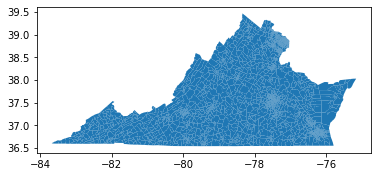

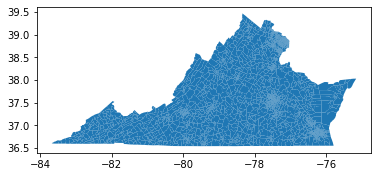

In [45]:
join = gpd.GeoDataFrame(pd.merge(df_with_absentee_reallocated, shp, on = 'unique_id_1', how = 'outer', indicator="first_merge"), crs = proj)
print('joined election results shapefile (RDH) followed by VESTs final file')
join.plot()
final.plot()

In [46]:
join["first_merge"].value_counts()

both          2438
left_only       24
right_only      10
Name: first_merge, dtype: int64

## Shapefile comparison:

In [52]:
shp_final_merge = pd.merge(join[join["first_merge"]=="both"], final, on = 'unique_id_1', how = 'outer', suffixes = ['_x', '_y'],indicator=True)

In [53]:
shp_final_merge["_merge"].value_counts()

both          2438
right_only      25
left_only        0
Name: _merge, dtype: int64

In [54]:
both = shp_final_merge[shp_final_merge["_merge"]=="both"]
source_geoms = gpd.GeoDataFrame(both,geometry="geometry_x",crs=final.crs)
vest_geoms = gpd.GeoDataFrame(both,geometry="geometry_y",crs=final.crs)
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

True     1771
False     667
dtype: int64


1) For 9 - Bells Mill (CD 4) difference in area is 2.8494320033778533
2) For 14 - Grassfield (CD 4) difference in area is 2.538696824575388
3) For 15 - B M Williams (CD 3) difference in area is 1.1457984206821203
4) For 36 - Great Bridge Baptist Church (CD 4) difference in area is 1.7854534822636545
5) For 51 - Coopers Way (CD 4) difference in area is 2.158233200662478
6) For 213 - Southside (CD 7) difference in area is 1.1100188908965825
7) For 304 - Winfrees Store (CD 4) difference in area is 7.916663970014204
8) For 309 - Skinquarter (CD 7) difference in area is 11.69378938112867
9) For 402 - Genito (CD 7) difference in area is 2.248562299915324
10) For 301 - South difference in area is 2.47207267955882
11) For 401 - Central difference in area is 2.47207267955882
12) For 202 - Sandy Hook difference in area is 1.0661449758085542
13) For 401 - Shallow Well difference in area is 2.697575844323418
14) For 402 - Centerville difference in area is 2.6986443230844803
15) For 201 - Beaverdam

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/plotting.py:384: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


23) For 104 - Titustown (CD 3) difference in area is 2.0626894059507426
24) For 101 - Farmville difference in area is 2.494664601970844
25) For 201 - Lockett difference in area is 2.9363555643566994
26) For 301 - Leigh difference in area is 2.9322856710127154
27) For 502 - Buffalo Hts difference in area is 2.2936352595016762
28) For 601 - Prospect difference in area is 1.1636917373493523
29) For 210 - Penn (CD 11) difference in area is 2.1695885815974254
30) For 103 - Glenvar (CD 9) difference in area is 1.1428642396626618
31) For 103 - Travelers Rest (CD 7) difference in area is 1.161132075930226
32) For 402 - Parkside (CD 7) difference in area is 1.5286514996213678
33) For 302 - John F Kennedy (CD 4) difference in area is 2.6810275008244133
34) For 504 - Lake Cohoon (CD 4) difference in area is 2.106828692572283


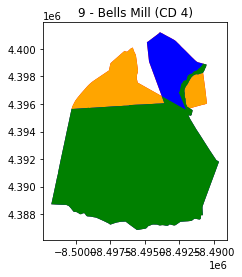

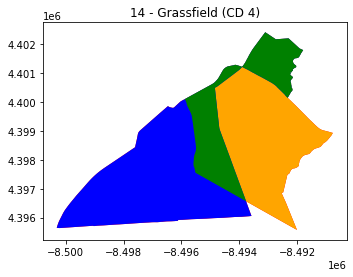

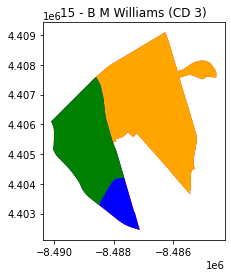

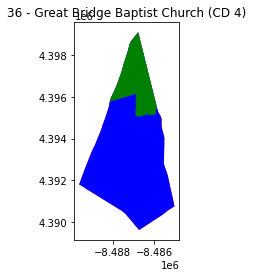

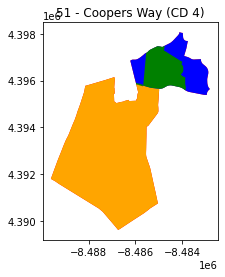

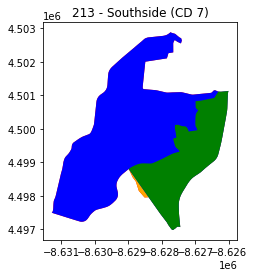

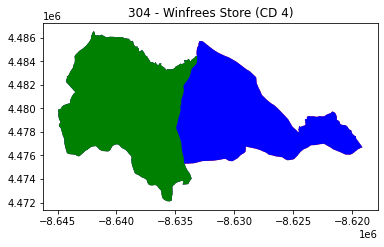

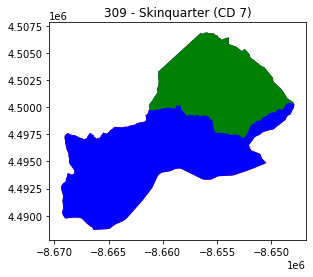

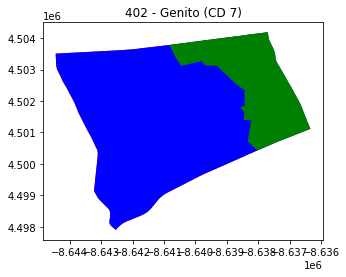

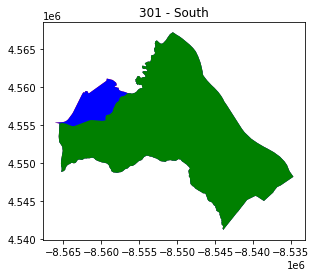

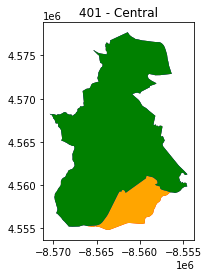

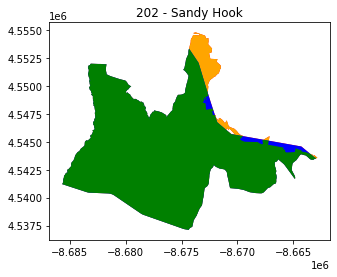

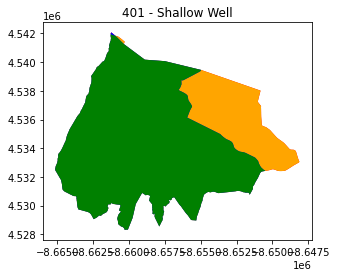

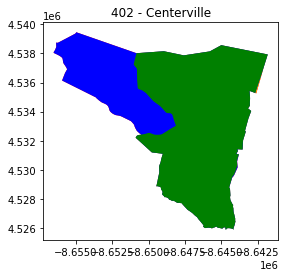

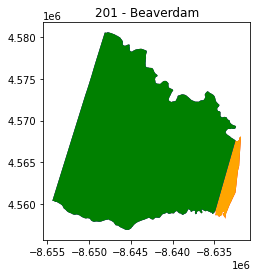

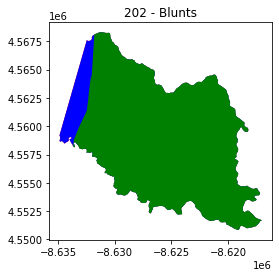

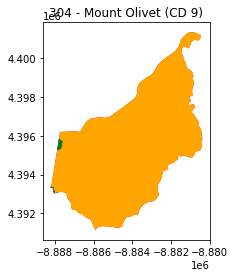

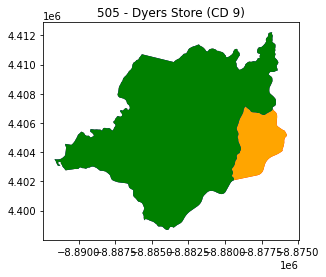

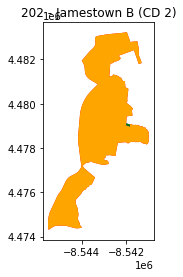

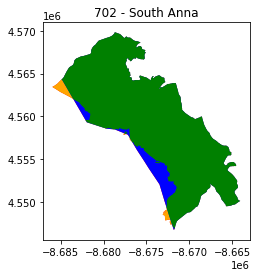

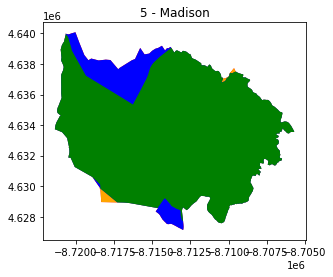

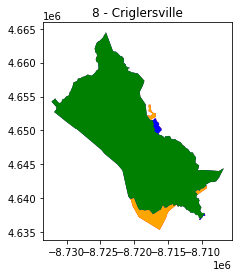

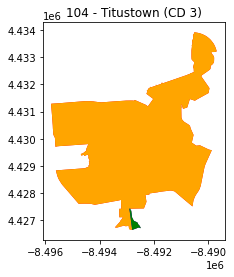

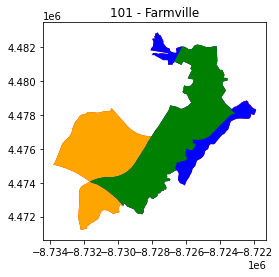

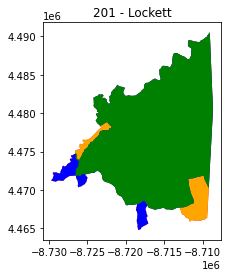

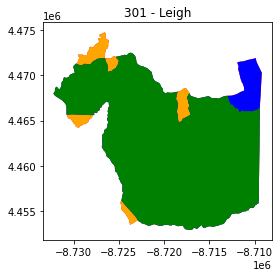

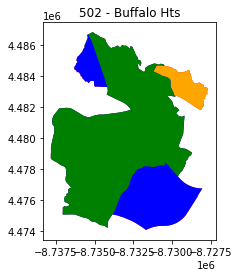

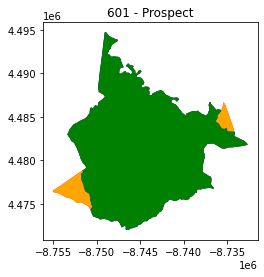

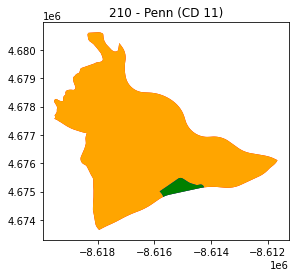

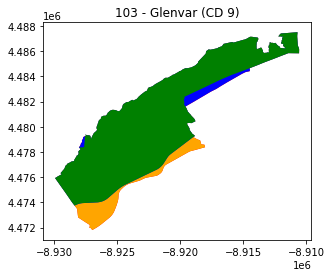

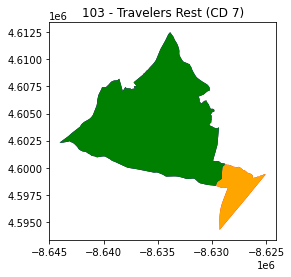

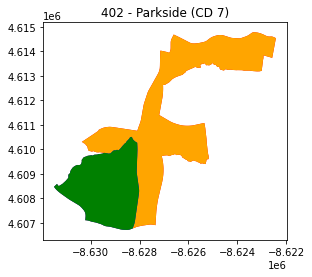

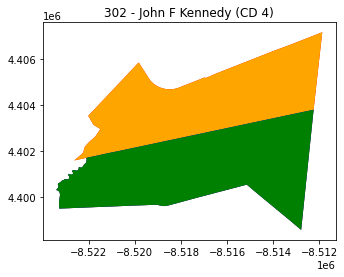

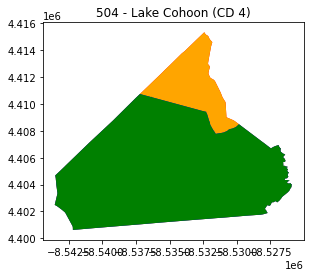

In [55]:
count = 0
area_list = []
big_diff = pd.DataFrame(columns=["area"])
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))

    if (area > 1):
        count += 1
        name = source_geoms.at[i,"Pct"]
        big_diff.loc[name]=area
        print(str(count)+") For " + name + " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(name)

In [56]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

(2438, 1)
1791 precincts w/ a difference of 0 km^2
535 precincts w/ a difference between 0 and .1 km^2
61 precincts w/ a difference between .1 and .5 km^2
17 precincts w/ a difference between .5 and 1 km^2
15 precincts w/ a difference between 1 and 2 km^2
17 precincts w/ a difference between 2 and 5 km^2
2 precincts w/ a difference greater than 5 km^2


## Election result comparison:

In [31]:
column_list = ['G18USSDKAI', 'G18USSRSTE', 'G18USSLWAT', 'G18USSOWRI']

In [32]:
print(df_with_absentee_reallocated["unique_id_1"].value_counts())
print(final["unique_id_1"].value_counts())
print(df_with_absentee_reallocated.shape)
print(final.shape)
print(final[~(final["unique_id_1"].isin(list(df_with_absentee_reallocated["unique_id_1"])))])

073302    1
810085    1
031602    1
680401    1
169603    1
         ..
550048    1
550028    1
013053    1
710311    1
650106    1
Name: unique_id_1, Length: 2462, dtype: int64
073302    1
107703    1
161403    1
510205    1
081202    1
         ..
800201    1
107218    1
760909    1
107820    1
187402    1
Name: unique_id_1, Length: 2463, dtype: int64
(2462, 23)
(2463, 11)
    COUNTYFP        LOCALITY   VTDST       PRECINCT  G18USSDKAI  G18USSRSTE  \
600      059  Fairfax County  000700  Fairfax Court           0           0   

     G18USSLWAT  G18USSOWRI  \
600           0           0   

                                              geometry unique_id unique_id_1  
600  POLYGON Z ((-77.31648 38.84615 0.00000, -77.31...    059700      059700  


In [33]:
final_df_merge = pd.merge(join, final, on = 'unique_id_1', how = 'outer', suffixes = ('_x', '_y'))

In [34]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["unique_id_1"]), "(V)","{:.>5}".format(int(df.iloc[j][right_Data]))," (S){:.>5}".format(int(df.iloc[j][left_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["unique_id_1"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["unique_id_1"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [35]:
validater_row(final_df_merge, column_list)

G18USSDKAI ..................................................................001101 (V) ..556  (S)..557 (D):   -1
G18USSDKAI ..................................................................001202 (V) ..316  (S)..317 (D):   -1
G18USSDKAI ..................................................................001301 (V) ..588  (S)..589 (D):   -1
G18USSDKAI ..................................................................001403 (V) ...45  (S)...44 (D):    1
G18USSDKAI ..................................................................001502 (V) ..356  (S)..357 (D):   -1
G18USSDKAI ..................................................................001701 (V) ..864  (S)..863 (D):    1
G18USSDKAI ..................................................................001801 (V) ..245  (S)..244 (D):    1
G18USSDKAI ..................................................................001901 (V) ..994  (S)..993 (D):    1
G18USSRSTE ..................................................................003101 (V) 

G18USSDKAI ..................................................................013045 (V) .1413  (S).1412 (D):    1
G18USSLWAT ..................................................................013046 (V) ...89  (S)...88 (D):    1
G18USSRSTE ..................................................................013047 (V) ..166  (S)..167 (D):   -1
G18USSDKAI ..................................................................013048 (V) .1312  (S).1313 (D):   -1
G18USSRSTE ..................................................................013049 (V) ..159  (S)..160 (D):   -1
G18USSDKAI ..................................................................013050 (V) .1458  (S).1457 (D):    1
G18USSDKAI ..................................................................013051 (V) ..487  (S)..486 (D):    1
G18USSRSTE ..................................................................013051 (V) ..131  (S)..132 (D):   -1
G18USSDKAI ..................................................................013052 (V) 

G18USSRSTE ..................................................................041107 (V) ..827  (S)..828 (D):   -1
G18USSRSTE ..................................................................041109 (V) .1387  (S).1386 (D):    1
G18USSDKAI ..................................................................041110 (V) ..690  (S)..689 (D):    1
G18USSRSTE ..................................................................041112 (V) ..774  (S)..775 (D):   -1
G18USSRSTE ..................................................................041202 (V) ..708  (S)..709 (D):   -1
G18USSDKAI ..................................................................041203 (V) ..281  (S)..282 (D):   -1
G18USSRSTE ..................................................................041205 (V) ..633  (S)..634 (D):   -1
G18USSDKAI ..................................................................041206 (V) .1156  (S).1157 (D):   -1
G18USSRSTE ..................................................................041207 (V) 

G18USSDKAI ..................................................................059113 (V) .1989  (S).1990 (D):   -1
G18USSRSTE ..................................................................059113 (V) ..820  (S)..819 (D):    1
G18USSOWRI ..................................................................059113 (V) ...13  (S)...12 (D):    1
G18USSRSTE ..................................................................059115 (V) ..422  (S)..423 (D):   -1
G18USSDKAI ..................................................................059117 (V) .1277  (S).1278 (D):   -1
G18USSRSTE ..................................................................059117 (V) ..626  (S)..625 (D):    1
G18USSDKAI ..................................................................059118 (V) .2096  (S).2097 (D):   -1
G18USSRSTE ..................................................................059118 (V) ..660  (S)..659 (D):    1
G18USSLWAT ..................................................................059118 (V) 

G18USSDKAI ..................................................................059426 (V) .1027  (S).1028 (D):   -1
G18USSDKAI ..................................................................059427 (V) .1444  (S).1443 (D):    1
G18USSRSTE ..................................................................059427 (V) ..443  (S)..444 (D):   -1
G18USSRSTE ..................................................................059429 (V) ..240  (S)..241 (D):   -1
G18USSRSTE ..................................................................059503 (V) ..259  (S)..260 (D):   -1
G18USSRSTE ..................................................................059508 (V) ..522  (S)..523 (D):   -1
G18USSDKAI ..................................................................059510 (V) .1125  (S).1126 (D):   -1
G18USSRSTE ..................................................................059510 (V) ..378  (S)..379 (D):   -1
G18USSRSTE ..................................................................059511 (V) 

G18USSDKAI ..................................................................061103 (V) ..395  (S)..396 (D):   -1
G18USSRSTE ..................................................................061103 (V) ..518  (S)..519 (D):   -1
G18USSRSTE ..................................................................061105 (V) ..540  (S)..541 (D):   -1
G18USSDKAI ..................................................................061106 (V) ..497  (S)..498 (D):   -1
G18USSRSTE ..................................................................061201 (V) .1017  (S).1016 (D):    1
G18USSDKAI ..................................................................061302 (V) ..785  (S)..784 (D):    1
G18USSRSTE ..................................................................061501 (V) ..716  (S)..715 (D):    1
G18USSDKAI ..................................................................061503 (V) ..659  (S)..658 (D):    1
G18USSDKAI ..................................................................063101 (V) 

G18USSDKAI ..................................................................650203 (V) ..899  (S)..898 (D):    1
G18USSRSTE ..................................................................650203 (V) ..443  (S)..444 (D):   -1
G18USSRSTE ..................................................................650204 (V) ..418  (S)..417 (D):    1
G18USSDKAI ..................................................................650205 (V) .1214  (S).1215 (D):   -1
G18USSRSTE ..................................................................650208 (V) ..861  (S)..860 (D):    1
G18USSLWAT ..................................................................650208 (V) ...36  (S)...37 (D):   -1
G18USSRSTE ..................................................................650210 (V) ..517  (S)..516 (D):    1
G18USSRSTE ..................................................................650213 (V) .1108  (S).1107 (D):    1
G18USSDKAI ..................................................................650214 (V) 

G18USSRSTE ..................................................................087517 (V) ..355  (S)..356 (D):   -1
G18USSRSTE ..................................................................087518 (V) ..772  (S)..771 (D):    1
G18USSRSTE ..................................................................089102 (V) ..610  (S)..609 (D):    1
G18USSDKAI ..................................................................089103 (V) ..331  (S)..332 (D):   -1
G18USSRSTE ..................................................................089201 (V) ..302  (S)..303 (D):   -1
G18USSRSTE ..................................................................089203 (V) ..211  (S)..212 (D):   -1
G18USSDKAI ..................................................................089302 (V) ..342  (S)..341 (D):    1
G18USSRSTE ..................................................................089303 (V) ..589  (S)..588 (D):    1
G18USSRSTE ............................................................089304(CD 5) (V) 

G18USSDKAI ..................................................................683001 (V) .1316  (S).1317 (D):   -1
G18USSDKAI ..................................................................683003 (V) .1534  (S).1535 (D):   -1
G18USSDKAI ..................................................................683005 (V) .1242  (S).1241 (D):    1
G18USSDKAI ..................................................................683006 (V) .1092  (S).1091 (D):    1
G18USSDKAI ..................................................................690004 (V) ..648  (S)..647 (D):    1
G18USSRSTE ..................................................................690004 (V) ..273  (S)..274 (D):   -1
G18USSDKAI ..................................................................690005 (V) ..549  (S)..550 (D):   -1
G18USSRSTE ..................................................................690005 (V) ..776  (S)..775 (D):    1
G18USSDKAI ..................................................................115002 (V) 

G18USSRSTE ..................................................................137101 (V) ..909  (S)..908 (D):    1
G18USSDKAI ..................................................................137102 (V) ..722  (S)..721 (D):    1
G18USSRSTE ..................................................................137102 (V) ..769  (S)..770 (D):   -1
G18USSRSTE ..................................................................137301 (V) ..850  (S)..851 (D):   -1
G18USSDKAI ..................................................................137402 (V) ..677  (S)..678 (D):   -1
G18USSRSTE ..................................................................137402 (V) ..783  (S)..784 (D):   -1
G18USSRSTE ..................................................................137501 (V) ..943  (S)..942 (D):    1
G18USSRSTE ..................................................................137502 (V) .1088  (S).1087 (D):    1
G18USSDKAI ..................................................................730301 (V) 

G18USSDKAI ..................................................................161504 (V) ..616  (S)..617 (D):   -1
G18USSRSTE ..................................................................161504 (V) ..487  (S)..488 (D):   -1
G18USSDKAI ..................................................................161507 (V) ..822  (S)..821 (D):    1
G18USSDKAI ..................................................................770001 (V) .1171  (S).1170 (D):    1
G18USSRSTE ..................................................................770001 (V) ..252  (S)..253 (D):   -1
G18USSDKAI ..................................................................770004 (V) ..801  (S)..800 (D):    1
G18USSRSTE ..................................................................770004 (V) ..497  (S)..498 (D):   -1
G18USSRSTE ..................................................................770006 (V) ..536  (S)..535 (D):    1
G18USSDKAI ..................................................................770009 (V) 

G18USSDKAI ..................................................................179402 (V) .1901  (S).1900 (D):    1
G18USSRSTE ..................................................................179402 (V) ..847  (S)..848 (D):   -1
G18USSDKAI ..................................................................179404 (V) ..746  (S)..745 (D):    1
G18USSRSTE ..................................................................179404 (V) ..860  (S)..861 (D):   -1
G18USSDKAI ..................................................................179501 (V) .1226  (S).1227 (D):   -1
G18USSDKAI ..................................................................179502 (V) ..942  (S)..941 (D):    1
G18USSRSTE ..................................................................179503 (V) ..884  (S)..883 (D):    1
G18USSRSTE ..................................................................179601 (V) .1018  (S).1017 (D):    1
G18USSDKAI ..................................................................790301 (V) 

G18USSDKAI ..................................................................810065 (V) ..967  (S)..966 (D):    1
G18USSDKAI ..................................................................810068 (V) ..875  (S)..876 (D):   -1
G18USSRSTE ..................................................................810069 (V) ..357  (S)..358 (D):   -1
G18USSLWAT ..................................................................810069 (V) ...23  (S)...24 (D):   -1
G18USSDKAI ..................................................................810074 (V) .1039  (S).1038 (D):    1
G18USSRSTE ..................................................................810075 (V) .1157  (S).1158 (D):   -1
G18USSDKAI ..................................................................810076 (V) .1125  (S).1124 (D):    1
G18USSDKAI ..................................................................810077 (V) ..887  (S)..888 (D):   -1
G18USSDKAI ..................................................................810078 (V) 